In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, classification_report
import textwrap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split,StratifiedGroupKFold
from imblearn.over_sampling import SMOTENC, SMOTE#, make_pipeline
#from imblearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline, Pipeline
#procs_path='/'.join(os.getcwd().split('/')[0:4])+ '/mimiciv/hosp_icu/'
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
print(fileloc_data)
#############################################
df_main=pd.read_csv(fileloc_data+'maskedDAIsy_MainDectoolEDEQ_Visit1_Only.tsv', sep='\t', decimal=',')
print(df_main.columns)
print(df_main['pid'].nunique(), df_main['intid'].nunique())
df_main.head(3)

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/
Index(['intid', 'seq_num-edeq', 'EDEQscore', 'pid', 'p_startdate',
       'p_dischargedate', 'age', 'bsex', 'edu_level', 'edu_comp',
       'Highest_Edu', 'EDtype', 'icd9_code', 'icd9_lab', 'BMI', 'IND_anders',
       'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit',
       'IND_depressie_comorbiditeit', 'IND_duur_stoornis_2plus_jaar',
       'IND_eerdere_spec_behandeling_zonder_effect',
       'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
       'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten',
       'andere_comorbiditeiten', 'duur_stoornis_in_jaren', 'interpretation',
       'leeftijd_invullen', 'p_dectool_invultijd', 'seq_num-dec',
       'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde', 'Split'],
      dtype='object')
298 300


,intid,seq_num-edeq,EDEQscore,pid,p_startdate,p_dischargedate,age,bsex,edu_level,edu_comp,...,andere_comorbiditeiten,duur_stoornis_in_jaren,interpretation,leeftijd_invullen,p_dectool_invultijd,seq_num-dec,uitslag_waarde,verstoord_eetpatroon,volgorde,Split
0,1491.0,1,4.76,0,2143-03-08 00:00:00,NaN,47,Vrouw,"HAVO, HBS, VWO, Atheneum. Gymnasium of MBO (MT...",MBOHAVOVWO,...,vermoeden van persoonlijkheidsprobl.,25,Geïndiceerd voor hoogspecialistische zorg op b...,47,2142-12-14 00:00:00,1,3,NaN,1,Train
1,1315.0,1,4.62,4,2142-01-21 00:00:00,2142-10-03 00:00:00,19,Vrouw,"HAVO, HBS, VWO, Atheneum. Gymnasium of MBO (MT...",MBOHAVOVWO,...,NaN,NaN,Geïndiceerd voor hoogspecialistische zorg op b...,19,2141-12-22 13:26:28,1,3,NaN,1,Train
2,1192.0,1,2.89,6,2141-09-20 00:00:00,2142-06-17 00:00:00,50,Vrouw,Lager onderwijs / lager Vormend Onderwijs / La...,LBO,...,"burnout, verslavingsgevoeligheid",30,Geïndiceerd voor hoogspecialistische zorg op b...,50,2141-05-06 16:03:35,1,4,Frequente eetbuien + braken.,1,Train


In [2]:
df_dec_mhcsf_sq48=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Visit1.tsv', sep='\t', decimal=',')
print(df_dec_mhcsf_sq48['pid'].nunique(),df_dec_mhcsf_sq48['intid'].nunique())
pid_per_intid=df_dec_mhcsf_sq48['pid'].value_counts()
print(pid_per_intid)
print('PIDs repeated in INTIDs: ', pid_per_intid[pid_per_intid.values>1])
df_dec_mhcsf_sq48[['Split', 'intid', 'pid', 'EDtype']].loc[df_dec_mhcsf_sq48['pid'].astype(float).isin([461.0,530.0])]
#df_dectool_first.head(4)

294 296
pid
461     2
530     2
1123    1
1120    1
1110    1
       ..
505     1
497     1
489     1
482     1
526     1
Name: count, Length: 294, dtype: int64
PIDs repeated in INTIDs:  pid
461    2
530    2
Name: count, dtype: int64


,Split,intid,pid,EDtype
89,Train,1200,461,Bulimia nervosa
90,Train,1626,461,Others
103,Train,1190,530,Anorexia nervosa
104,Train,1329,530,Anorexia nervosa


In [3]:
df_edeq=pd.read_csv(fileloc_data+'maskedDAIsy_EDEQ_Score.tsv', sep='\t', decimal=',')
print(df_edeq.shape)
print(df_edeq[['Split', 'pid', 'intid', 'seq_num-edeq', 'p_edeq_filled_date', 'EDEQscore']].loc[df_edeq['pid'].astype(float).isin(
    [461.0, 530.0])].sort_values(by=['intid', 'pid', 'seq_num-edeq'], ascending=[True, True, True]))


(4904, 13)
      Split  pid   intid  seq_num-edeq p_edeq_filled_date  EDEQscore
1561  Train  530  1190.0             1         2141-01-29       4.54
1562  Train  530  1190.0             2         2141-04-28       2.14
1563  Train  530  1190.0             3         2141-07-27       1.08
1564  Train  530  1190.0             4         2141-10-25       2.45
1385  Train  461  1200.0             1         2141-04-07       4.82
1565  Train  530  1329.0             1         2142-01-06       3.59
1566  Train  530  1329.0             2         2142-04-13       0.83
1567  Train  530  1329.0             3         2142-11-12       2.98
1568  Train  530  1329.0             4         2143-05-09       3.29
1569  Train  530  1329.0             5         2144-01-31       4.15
1570  Train  530  1329.0             6         2144-02-08       3.56
1386  Train  461  1626.0             1         2143-09-25       3.78
1387  Train  461  1626.0             2         2143-09-25       4.13
1388  Train  461  1626.

In [4]:
print(df_dec_mhcsf_sq48.columns)
colsMain=['age','bsex','Highest_Edu','BMI', 'IND_anders', 'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit',
    'IND_depressie_comorbiditeit', 'IND_duur_stoornis_2plus_jaar', 'IND_eerdere_spec_behandeling_zonder_effect', 
    'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI', 'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten',
    'andere_comorbiditeiten', 'duur_stoornis_in_jaren', 'interpretation', 'leeftijd_invullen','uitslag_waarde', 
    'verstoord_eetpatroon', 'volgorde', 'Split', 'EDEQscore','EDtype']
colsMHSCF_SQ48=['age', 'bsex', 'BMI', 'Highest_Edu', 'Vijandigheid', 'Agorafobie', 'Angst', 'Cognitieve_Klachten','Depressie',
    'Somatische_Klachten', 'Sociale_Fobie', 'Vitaliteit_Optimisme', 'Werk_Studie', 'IND_anders','IND_as_I_II_comorbiditeiten',
    'IND_borderline_comorbiditeit', 'IND_depressie_comorbiditeit','IND_duur_stoornis_2plus_jaar', 
    'IND_eerdere_spec_behandeling_zonder_effect','IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
    'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'andere_comorbiditeiten', 'duur_stoornis_in_jaren',
    'leeftijd_invullen', 'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde','EmotionWB', 'PsychWB', 
    'SocialWB', 'mhcsf_score','SQ48score', 'EDEQscore', 'Split', 'EDtype']

df_dec_mhcsf_sq48[['IND_anders', 'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit', 'IND_depressie_comorbiditeit',
       'IND_duur_stoornis_2plus_jaar','IND_eerdere_spec_behandeling_zonder_effect', 'IND_ernstig_verstoord_eten', 
       'IND_extreem_laag_hoog_BMI','IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'age',
       'andere_comorbiditeiten','verstoord_eetpatroon', 'volgorde','EmotionWB', 'PsychWB']]

Index(['pid', 'intid', 'seq_num-sq48', 'Split', 'p_sq48_filled_date',
       'Vijandigheid', 'Agorafobie', 'Angst', 'Cognitieve_Klachten',
       'Depressie', 'Somatische_Klachten', 'Sociale_Fobie', 'SQ48score',
       'Vitaliteit_Optimisme', 'Werk_Studie', 'BMI', 'EDEQscore', 'EDtype',
       'Highest_Edu', 'IND_anders', 'IND_as_I_II_comorbiditeiten',
       'IND_borderline_comorbiditeit', 'IND_depressie_comorbiditeit',
       'IND_duur_stoornis_2plus_jaar',
       'IND_eerdere_spec_behandeling_zonder_effect',
       'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
       'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'age',
       'andere_comorbiditeiten', 'bsex', 'duur_stoornis_in_jaren', 'edu_level',
       'icd9_lab', 'interpretation', 'leeftijd_invullen',
       'p_dectool_invultijd', 'p_dischargedate', 'p_startdate', 'seq_num-dec',
       'seq_num-edeq', 'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde',
       'EmotionWB', 'PsychWB', 'SocialWB', 'mhcsf_score'

,IND_anders,IND_as_I_II_comorbiditeiten,IND_borderline_comorbiditeit,IND_depressie_comorbiditeit,IND_duur_stoornis_2plus_jaar,IND_eerdere_spec_behandeling_zonder_effect,IND_ernstig_verstoord_eten,IND_extreem_laag_hoog_BMI,IND_ocd_comorbiditeit,aantal_eerdere_trajecten,age,andere_comorbiditeiten,verstoord_eetpatroon,volgorde,EmotionWB,PsychWB
0,1,1,0,0,1,1,0,0,0,8.0,47,vermoeden van persoonlijkheidsprobl.,NaN,1,3.3,2.5
1,1,1,0,0,0,0,1,1,0,NaN,19,NaN,NaN,1,2.7,2.7
2,1,1,1,0,1,1,1,0,0,1.0,50,"burnout, verslavingsgevoeligheid",Frequente eetbuien + braken.,1,3.0,2.0
3,0,0,0,0,0,1,1,1,0,1.0,21,NaN,"Sterk restrictief, afvallen ondanks eetlijst d...",1,3.7,3.2
4,1,0,0,0,0,0,1,0,0,NaN,16,ASS,Restrictief eetpatroon,1,1.7,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,1,1,0,1,1,0,1,0,0,NaN,23,ADD,eetbuien,1,2.0,1.7
292,1,1,0,1,1,0,1,1,0,NaN,22,"verdere diagnostiek nodig, mogelijk ADHD/ASS?",Zeer restrictief vanuit moeite met eten (de ha...,1,1.3,1.0
293,1,1,0,0,1,0,1,0,0,NaN,18,Eerder was er sprake van een lichte depressie.,De eetstoornis kenmerkt zich door een beperken...,1,2.0,1.5
294,1,1,0,0,1,0,1,0,0,NaN,19,stemmingklachten en PTSS,zeer restrictief eetpatroon in combinatie met ...,1,1.3,0.7


### Correlation Matrix of the combined datasets

In [122]:
df_Questionnaires=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Honos_Lav_Visit1.tsv', sep='\t', decimal=',')
df_Questionnaires.columns
#colsMain=[ 'age', 'bsex','Highest_Edu', 'EDtype']
colsDectools=['BMI', 'IND_eerdere_spec_behandeling_zonder_effect', 'aantal_eerdere_trajecten', 
    'IND_duur_stoornis_2plus_jaar', 'duur_stoornis_in_jaren', 'IND_as_I_II_comorbiditeiten',
    'IND_depressie_comorbiditeit', 'IND_borderline_comorbiditeit', 'IND_ocd_comorbiditeit', 'IND_anders',
    'IND_ernstig_verstoord_eten']
colsEDEQ=['eating', 'weight', 'bodyshape', 'lines', 'EDEQscore']
#colsEDQOL=['Psychologisch', 'FysiekCognitief','Financieel', 'WerkSchool', 'EDQOLscore']
colsHonos=['Somscore', 'Beperkingen', 'Functioneren', 'Gedragsproblemen', 'Symptomalogie', 'SocialeProblemen']
colsLAV=['Negatieve_Waardering', 'Gebrek_Vertrouwdheid', 'Algemene_Ontevredenheid', 'LAV_Score']
colsSQ48=['Vijandigheid','Agorafobie','Angst','Depressie', 'Cognitieve_Klachten','Somatische_Klachten', 'Sociale_Fobie',
          'Vitaliteit_Optimisme', 'Werk_Studie', 'SQ48score']
colsMHCSF=['EmotionWB', 'SocialWB', 'PsychWB', 'mhcsf_score']

colNames=['Main-Age', 'Main-BSex','Main-EduLevel', 'Main-ED_Codes', 'EDEQ-score','DT-BMI', 'DT-IND_prev_spec_int_wo_eff', 
'DT-num_prev_routes', 'DT-IND_Disorder_Duration_2+Yrs', 'DT-Disorder_Duration_Yrs', 'DT-IND_I_II_CMD', 'DT-IND_depressie_CMD',
'DT-IND_BDL_CMD', 'DT-IND_OCD_CMD', 'DT-IND_others','DT-IND_VDisturbdEating', 'Honos-Somscore', 'Honos-Beperkingen',
'Honos-Functioneren', 'Honos-Gedragsproblemen', 'Honos-Symptomalogie', 'Honos-SocialeProblemen''Lav-Neg_Waardering', 
'Lav-Gebrek_Vertrouwdheid', 'Lav-Alg_Ontevredenheid', 'Lav-Score', 'SQ48-Hostility','SQ48-Agorafobie','SQ48-Angst',
'SQ48-Depressie','SQ48-Cognitieve_Complain','SQ48-Somatische_Complain', 'SQ48-Sociale_Fobie','SQ48-Vitaliteit_Optimisme', 
'SQ48-Werk_Studie', 'SQ48-Score', 'MHCSF-EmotionWB', 'MHCSF-SocialWB', 'MHCSF-PsychWB', 'MHCSF-Score']  

df_Questionnaires['BMI']=df_Questionnaires['BMI'].astype(float)
df_Questionnaires['duur_stoornis_in_jaren']=df_Questionnaires['duur_stoornis_in_jaren'].astype(float)

df_train_explore=df_Questionnaires.loc[df_Questionnaires['Split']=='Train']
print(df_train_explore['bsex'].value_counts())
print(df_train_explore['EDtype'].value_counts())
df_train_explore['bsex'] = df_train_explore['bsex'].astype('category')
df_train_explore['biosex'] = df_train_explore['bsex'].cat.codes
df_train_explore['biosex']=df_train_explore['biosex'].astype(float)
df_train_explore['EDtype'] = df_train_explore['EDtype'].astype('category')
df_train_explore['ED_Codes'] = df_train_explore['EDtype'].cat.codes
df_train_explore['Highest_Edu'] = df_train_explore['Highest_Edu'].astype('category')
df_train_explore['Edu_codes'] = df_train_explore['Highest_Edu'].cat.codes
df_train_explore['Edu_codes']=df_train_explore['Edu_codes'].astype(float)
cols2consider=['age','biosex', 'Edu_codes','ED_Codes', 'EDEQscore']+colsDectools+colsHonos+colsLAV+colsSQ48+colsMHCSF

bsex
Vrouw    104
Man        3
Name: count, dtype: int64
EDtype
Anorexia nervosa    47
Binge-ED            19
Other ED            18
Bulimia nervosa     13
Others              10
Name: count, dtype: int64


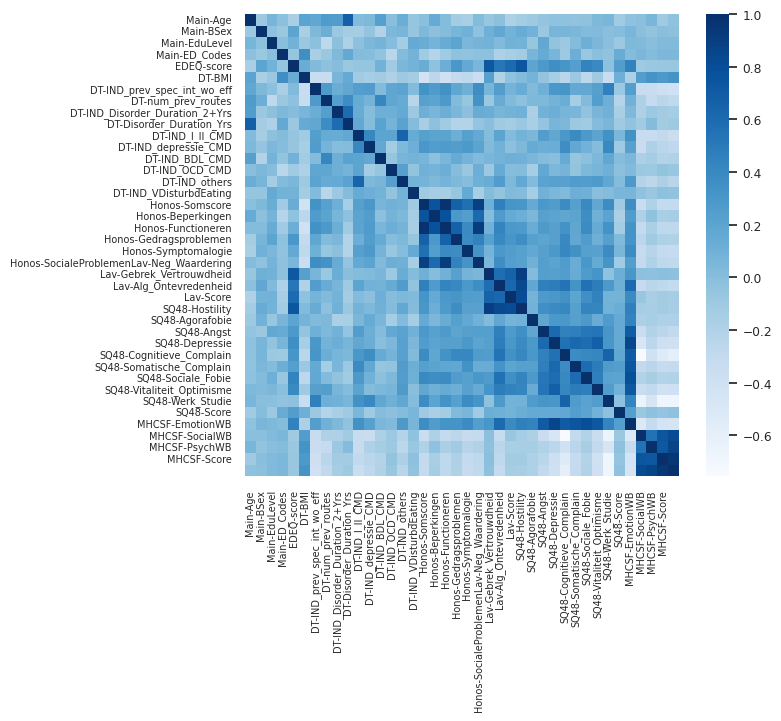

In [123]:
#df_dec_mhcsf_sq48
#cols2consider=np.setdiff1d(cols2consider, ['EDtypes', 'bsex'])+['Edu_codes', 'ED_Codes']
cc_df_train_explore=df_train_explore[cols2consider].corr(method='spearman')
import seaborn as sns
#print(df_train_explore['verstoord_eetpatroon'].value_counts())
plt.figure(figsize=(7,6))
sns.set_style('whitegrid')
sns.set(font_scale=0.8)
g=sns.heatmap(cc_df_train_explore, cmap="Blues", annot=False, fmt=".1f", xticklabels=colNames, yticklabels=colNames)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 7)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 7)
plt.savefig('figs/correlationMatrix.pdf')
#cc_df_train_explore.style.background_gradient(cmap='coolwarm').set_precision(2)
#df_train_explore.columns

In [124]:
df_Questionnaires['Diff']=df_Questionnaires['leeftijd_invullen']-df_Questionnaires['age']
df_Questionnaires[['intid', 'pid', 'leeftijd_invullen', 'age', 'Diff']].loc[df_Questionnaires['Diff'].abs()>1]

,intid,pid,leeftijd_invullen,age,Diff
4,794,56,55,52,3
127,1119,1484,33,31,2


### Visualizing Missing Values

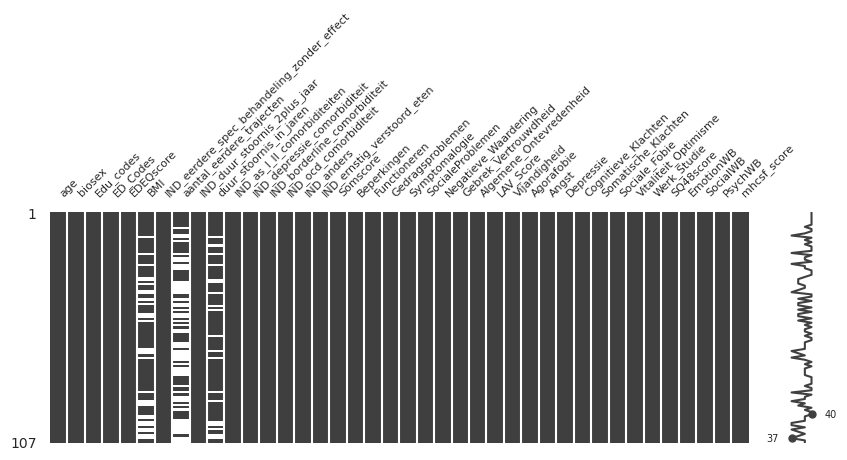

In [125]:
#!pip install missingno
import missingno as msno 
fig = msno.matrix(df_train_explore[cols2consider],figsize=(10, 3), fontsize=8)
grid_ax = fig.axes


In [126]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import pairwise_distances
from numpy.linalg import norm
from sklearn import metrics
cols2train=np.setdiff1d(cols2consider,['EDEQscore','ED_Codes'])
#zero_df_train=df_train_explore[cols2train].fillna(0)
labels_true=df_train_explore['ED_Codes']#df_Questionnaires['EDtype'].loc[df_Questionnaires['Split']=='Train']
nan_mean=np.nanmean(df_train_explore[cols2train].to_numpy(), axis=1)
nan_std=np.nanstd(df_train_explore[cols2train].to_numpy(), axis=1)
z_train_explore=((df_train_explore[cols2train].to_numpy().T-nan_mean)/nan_std).T
mask=~np.isnan(z_train_explore)
#mask=mask.astype(int)
pdist_cos = np.zeros((np.shape(z_train_explore)[0],np.shape(z_train_explore)[0]))
for i in range(np.shape(z_train_explore)[0]):
    for j in range(np.shape(z_train_explore)[0]):
        combo_mask=mask[i]& mask[j]
        temp_i, temp_j=z_train_explore[i], z_train_explore[j]
        c_tmp = np.dot(temp_i[combo_mask], temp_j[combo_mask])/(norm(temp_i[combo_mask])*norm(temp_j[combo_mask])) 
        pdist_cos[i][j] = c_tmp
#print(pdist_cos[:,:3])
#pdist_cos=pairwise_distances(z_train_explore, metric='cosine', force_all_finite='allow-nan')
af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=500, convergence_iter=20).fit(-1*pdist_cos)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels))
np.fill_diagonal(pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(pdist_cos, labels, metric="precomputed"))


Estimated number of clusters: 2
Homogeneity: 0.029
Completeness: 0.173
V-measure: 0.049
Adjusted Rand Index: 0.032
Adjusted Mutual Information: 0.024
Silhouette Coefficient: -0.115


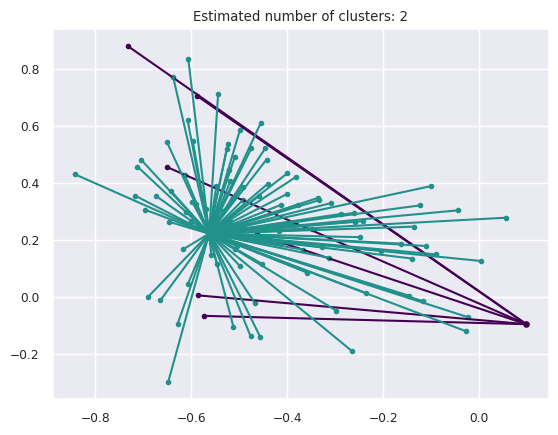

In [127]:
plt.figure(2)
plt.clf()
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_clusters_+1)))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = z_train_explore[cluster_centers_indices[k]]
    cluster_center=cluster_center[mask[cluster_centers_indices[k]]]
    plt.scatter(z_train_explore[class_members, 0], z_train_explore[class_members, 1], 
                color=col["color"], marker=".")
    plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
    for x in z_train_explore[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [128]:
#!pip install ppca
from ppca import PPCA
ppca = PPCA()
ppca.fit(data=z_train_explore, d=3, verbose=False)
variance_explained, components, model_params  = ppca.var_exp, ppca.data, ppca.C
component_mat = ppca.transform()
print(np.shape(components), np.shape(z_train_explore))
ppca_pdist_cos=pairwise_distances(component_mat, metric='cosine')
ppca_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=20).fit(-1*ppca_pdist_cos)
ppca_cluster_centers_indices = ppca_af.cluster_centers_indices_
ppca_labels = ppca_af.labels_
ppca_n_clusters_ = len(ppca_cluster_centers_indices)
print("Estimated number of clusters: %d" % ppca_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, ppca_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, ppca_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, ppca_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, ppca_labels))
print("Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, ppca_labels))
np.fill_diagonal(ppca_pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(ppca_pdist_cos, ppca_labels, metric="precomputed"))

(107, 38) (107, 38)
Estimated number of clusters: 11
Homogeneity: 0.218
Completeness: 0.135
V-measure: 0.167
Adjusted Rand Index: 0.031
Adjusted Mutual Information: 0.056
Silhouette Coefficient: 0.542


0 EDtype
Bulimia nervosa     3
Other ED            2
Binge-ED            1
Anorexia nervosa    0
Others              0
Name: count, dtype: int64
1 EDtype
Binge-ED            6
Anorexia nervosa    3
Bulimia nervosa     2
Other ED            2
Others              0
Name: count, dtype: int64
2 EDtype
Binge-ED            3
Anorexia nervosa    2
Bulimia nervosa     2
Other ED            0
Others              0
Name: count, dtype: int64
3 EDtype
Anorexia nervosa    6
Other ED            2
Binge-ED            1
Bulimia nervosa     1
Others              0
Name: count, dtype: int64
4 EDtype
Anorexia nervosa    9
Other ED            2
Bulimia nervosa     1
Others              1
Binge-ED            0
Name: count, dtype: int64
5 EDtype
Anorexia nervosa    4
Bulimia nervosa     1
Others              1
Binge-ED            0
Other ED            0
Name: count, dtype: int64
6 EDtype
Anorexia nervosa    2
Bulimia nervosa     2
Other ED            1
Others              1
Binge-ED            0
Name: count

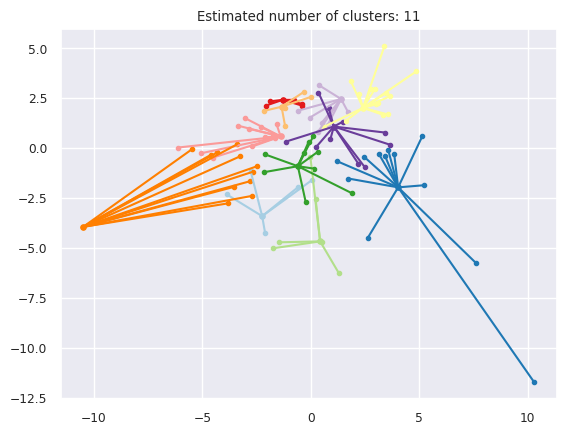

In [129]:
plt.figure(3)
plt.clf()
colors = plt.cycler("color", plt.cm.Paired(np.linspace(0, 1, ppca_n_clusters_+1)))
cluster_median_profile={}
for k, col in zip(range(ppca_n_clusters_), colors):
    class_members = ppca_labels == k
    print(k, df_train_explore['EDtype'].iloc[ppca_labels == k].value_counts())
    cluster_median_profile[k]=df_train_explore[cols2consider].iloc[class_members].median(skipna=True)
    cluster_median_profile[k]['Edu_codes']=df_train_explore['Highest_Edu'].iloc[class_members].value_counts().keys()[0]
    cluster_median_profile[k]['ED_Codes']=df_train_explore['EDtype'].iloc[class_members].value_counts().keys()[0]
    cluster_center = component_mat[ppca_cluster_centers_indices[k]]
    plt.scatter(component_mat[class_members, 0], component_mat[class_members, 1], 
                color=col["color"], marker=".")
    plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
    for x in component_mat[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])

plt.title("Estimated number of clusters: %d" % ppca_n_clusters_)
plt.show()

In [130]:
cluster_df=pd.DataFrame.from_dict(cluster_median_profile).T
cluster_df

,age,biosex,Edu_codes,ED_Codes,EDEQscore,BMI,IND_eerdere_spec_behandeling_zonder_effect,aantal_eerdere_trajecten,IND_duur_stoornis_2plus_jaar,duur_stoornis_in_jaren,...,Cognitieve_Klachten,Somatische_Klachten,Sociale_Fobie,Vitaliteit_Optimisme,Werk_Studie,SQ48score,EmotionWB,SocialWB,PsychWB,mhcsf_score
0,24.5,1.0,Verkort MBO,Bulimia nervosa,4.35,23.85,0.0,1.5,1.0,2.5,...,11.0,6.5,10.5,10.0,8.5,55.0,3.0,2.7,3.15,2.9
1,22.0,1.0,MBO (MTS) afgerond,Binge-ED,4.56,29.0,0.0,1.0,1.0,4.0,...,10.0,7.0,12.0,9.0,7.0,59.0,3.0,2.2,2.7,2.3
2,39.0,1.0,Onbekend,Binge-ED,3.03,40.0,0.0,6.0,1.0,20.0,...,8.0,3.0,10.0,10.0,2.0,37.0,3.3,3.0,3.2,3.1
3,22.0,1.0,VMBO-T,Anorexia nervosa,4.94,17.7,0.5,1.0,1.0,2.5,...,10.5,8.0,10.0,12.5,6.0,65.0,2.5,1.7,2.15,2.05
4,27.0,1.0,Onbekend,Anorexia nervosa,4.42,15.0,1.0,3.5,1.0,9.0,...,14.0,12.0,14.0,16.0,0.0,81.0,1.3,1.0,1.5,1.4
5,33.0,1.0,Onbekend,Anorexia nervosa,4.65,16.4,1.0,1.5,1.0,3.0,...,14.0,18.0,17.0,17.5,4.5,109.0,1.35,1.0,0.95,1.1
6,23.0,1.0,MBO (MTS) afgerond,Anorexia nervosa,2.645,17.5,1.0,1.0,1.0,2.5,...,16.0,14.0,10.5,18.0,12.0,86.5,1.15,1.1,1.35,1.05
7,34.5,1.0,HBO bachelor,Anorexia nervosa,3.42,21.0,1.0,1.0,1.0,22.0,...,11.5,7.5,8.0,13.0,9.5,56.5,2.7,1.9,1.9,2.05
8,23.0,1.0,MBO (MTS) afgerond,Anorexia nervosa,5.125,18.1,1.0,1.0,1.0,4.0,...,15.5,14.5,16.5,15.0,11.0,95.5,0.85,1.0,1.0,0.95
9,27.0,1.0,HBO bachelor,Other ED,3.27,18.3,0.0,1.0,1.0,10.0,...,14.0,11.0,13.0,13.0,7.0,72.0,2.3,1.8,2.2,2.4


0.0 4.03 5.95
0.0 3.84 5.62
EDEQscore
(0.0, 1.5]    12
(1.5, 3.0]    43
(3.0, 4.5]    97
(4.5, 6.0]    70
Name: pid, dtype: int64
First visit only:
 EDtype
Anorexia nervosa    83
Binge-ED            40
Bulimia nervosa     41
Other ED            37
Others              22
Name: intid, dtype: int64 (223, 33)
Second visit only:
 EDtype
Anorexia nervosa    83
Binge-ED            40
Bulimia nervosa     41
Other ED            37
Others              22
Name: intid, dtype: int64 (223, 33)
Third visit only:
 EDtype
Anorexia nervosa    47
Binge-ED            24
Bulimia nervosa     26
Other ED            21
Others              15
Name: intid, dtype: int64 (133, 33)
Fourth visit only:
 EDtype
Anorexia nervosa    32
Binge-ED            14
Bulimia nervosa     13
Other ED            13
Others              12
Name: intid, dtype: int64 (84, 33)


## Train and test splits and checking the class distribution in train and test
### Train and test sets created such that both have at similar distribution of patients present in till at least second follow-up and all other patients (only 1 visit, only 1 follow-up, all three follow-ups).

In [5]:
label_2fus=df_mdect_ed_third['EDtype'].to_list()
feature_list=np.setdiff1d(df_main_dectools.columns, ['EDtype'])
Xtrain_2followups, Xtest_2followups, ytrain_2fu, ytest_2fu = train_test_split(df_mdect_ed_third[feature_list], label_2fus, 
                                                      test_size=0.25, random_state=42, stratify=label_2fus)
df_mdect_ed_rest=df_mdect_ed_first.loc[~df_mdect_ed_first['intid'].isin(df_mdect_ed_third['intid'].unique())].copy()
label_rest=df_mdect_ed_rest['EDtype'].to_list()
Xtrain_rest, Xtest_rest, ytrain_rest, ytest_rest = train_test_split(df_mdect_ed_rest[feature_list], label_rest, 
                                                      test_size=0.25, random_state=42, stratify=label_rest)
h_tr=np.union1d(Xtrain_2followups['intid'].astype(float).unique(), Xtrain_rest['intid'].astype(float).unique())
h_te=np.union1d(Xtest_2followups['intid'].astype(float).unique(), Xtest_rest['intid'].astype(float).unique())
print(len(h_tr), len(h_te))
print(df_mdect_ed_first['EDtype'].loc[df_mdect_ed_first['intid'].isin(h_tr)].value_counts())
print(df_mdect_ed_first['EDtype'].loc[df_mdect_ed_first['intid'].isin(h_te)].value_counts())

df_mdect_ed_first['Split']='Train'
df_mdect_ed_first['Split'].loc[df_mdect_ed_first['intid'].astype(float).isin(h_te)]='Test'
df_mdect_ed_second['Split']='Train'
df_mdect_ed_second['Split'].loc[df_mdect_ed_second['intid'].astype(float).isin(h_te)]='Test'
df_mdect_ed_third['Split']='Train'
df_mdect_ed_third['Split'].loc[df_mdect_ed_third['intid'].astype(float).isin(h_te)]='Test'
df_mdect_ed_fourth['Split']='Train'
df_mdect_ed_fourth['Split'].loc[df_mdect_ed_fourth['intid'].astype(float).isin(h_te)]='Test'

df_mdect_ed_first.to_csv(fileloc_data+'maskedDAIsy_MainDectoolEDEQ_Visit1_Only.tsv', sep='\t', decimal=',', index=False)
df_mdect_ed_second.to_csv(fileloc_data+'maskedDAIsy_MainDectoolEDEQ_Visit2_Only.tsv', sep='\t', decimal=',', index=False)
df_mdect_ed_third.to_csv(fileloc_data+'maskedDAIsy_MainDectoolEDEQ_Visit3_Only.tsv', sep='\t', decimal=',', index=False)
df_mdect_ed_fourth.to_csv(fileloc_data+'maskedDAIsy_MainDectoolEDEQ_Visit4_Only.tsv', sep='\t', decimal=',', index=False)

166 57
EDtype
Anorexia nervosa    62
Binge-ED            30
Bulimia nervosa     30
Other ED            28
Others              16
Name: count, dtype: int64
EDtype
Anorexia nervosa    21
Bulimia nervosa     11
Binge-ED            10
Other ED             9
Others               6
Name: count, dtype: int64


In [4]:
df_sq48=pd.read_csv(fileloc_data+'maskedDAIsy_SQ48_all.tsv', sep='\t', decimal=',')
freq_sq48=df_sq48['intid'].value_counts()
focus_intids_fusq48=np.array(freq_sq48[freq_sq48.values>=2].keys().astype(float))
df_sq48_fu=df_sq48.loc[df_sq48['intid'].astype(float).isin(focus_intids_fusq48)].copy()

print(df_main_dectools['EDtype'].loc[df_main_dectools['pid'].astype(float).isin(df_sq48_fu['pid'].unique())].value_counts())
print(df_main_dectools['EDtype'].loc[df_main_dectools['pid'].astype(float).isin(df_sq48['pid'].unique())].value_counts())
df_sq48.head(4)

EDtype
Anorexia nervosa    87
Bulimia nervosa     43
Binge-ED            39
Other ED            37
Others              24
Name: count, dtype: int64
EDtype
Anorexia nervosa    90
Bulimia nervosa     44
Binge-ED            40
Other ED            38
Others              24
Name: count, dtype: int64


,pid,intid,p_sq48_filled_date,Vijandigheid,Agorafobie,Angst,Cognitieve_Klachten,Depressie,Somatische_Klachten,Sociale_Fobie,Totaalscore,Vitaliteit_Optimisme,Werk_Studie
0,0,1491,2142-11-17,4.0,2.0,13.0,14.0,9.0,14.0,16.0,72.0,13.0,0.0
1,0,1491,2143-05-16,4.0,3.0,12.0,14.0,6.0,13.0,16.0,68.0,10.0,0.0
2,0,1491,2143-09-19,8.0,1.0,15.0,13.0,9.0,15.0,11.0,72.0,12.0,8.0
3,0,1491,2143-11-17,4.0,1.0,13.0,14.0,5.0,13.0,14.0,64.0,10.0,8.0


In [5]:
cols2include=np.setdiff1d(df_main_dectools.columns, ['intid'])
df_main_sq48=df_sq48.merge(df_main_dectools[cols2include], on='pid', how='inner')
print(df_main_sq48.columns)
#cols_main_sq48=['pid', 'p_startdate', 'p_dischargedate', 'age', 'bsex', 'Highest_Edu', 'EDtype', 'icd9_code','icd9_lab',
#        'intid_y', 'p_sq48_filled_date', 'Vijandigheid', 'Agorafobie', 'Angst', 'Cognitieve_Klachten', 'Depressie',
#       'Somatische_Klachten', 'Sociale_Fobie', 'Totaalscore','Vitaliteit_Optimisme', 'Werk_Studie']
#df_main_sq48=df_main_sq48[cols_main_sq]
df_main_sq48.head(4)

Index(['pid', 'intid', 'p_sq48_filled_date', 'Vijandigheid', 'Agorafobie',
       'Angst', 'Cognitieve_Klachten', 'Depressie', 'Somatische_Klachten',
       'Sociale_Fobie', 'Totaalscore', 'Vitaliteit_Optimisme', 'Werk_Studie',
       'BMI', 'EDtype', 'Highest_Edu', 'IND_anders',
       'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit',
       'IND_depressie_comorbiditeit', 'IND_duur_stoornis_2plus_jaar',
       'IND_eerdere_spec_behandeling_zonder_effect',
       'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
       'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'age',
       'andere_comorbiditeiten', 'bsex', 'duur_stoornis_in_jaren', 'edu_comp',
       'edu_level', 'icd9_code', 'icd9_lab', 'interpretation',
       'leeftijd_invullen', 'p_dectool_invultijd', 'p_dischargedate',
       'p_startdate', 'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde'],
      dtype='object')


,pid,intid,p_sq48_filled_date,Vijandigheid,Agorafobie,Angst,Cognitieve_Klachten,Depressie,Somatische_Klachten,Sociale_Fobie,...,icd9_code,icd9_lab,interpretation,leeftijd_invullen,p_dectool_invultijd,p_dischargedate,p_startdate,uitslag_waarde,verstoord_eetpatroon,volgorde
0,0,1491,2142-11-17,4.0,2.0,13.0,14.0,9.0,14.0,16.0,...,307.51,"Eetbuistoornis: matig, ernstig, zeer ernstig",Geïndiceerd voor hoogspecialistische zorg op b...,47,2142-12-14 00:00:00,NaN,2143-03-08,3,NaN,1
1,0,1491,2143-05-16,4.0,3.0,12.0,14.0,6.0,13.0,16.0,...,307.51,"Eetbuistoornis: matig, ernstig, zeer ernstig",Geïndiceerd voor hoogspecialistische zorg op b...,47,2142-12-14 00:00:00,NaN,2143-03-08,3,NaN,1
2,0,1491,2143-09-19,8.0,1.0,15.0,13.0,9.0,15.0,11.0,...,307.51,"Eetbuistoornis: matig, ernstig, zeer ernstig",Geïndiceerd voor hoogspecialistische zorg op b...,47,2142-12-14 00:00:00,NaN,2143-03-08,3,NaN,1
3,0,1491,2143-11-17,4.0,1.0,13.0,14.0,5.0,13.0,14.0,...,307.51,"Eetbuistoornis: matig, ernstig, zeer ernstig",Geïndiceerd voor hoogspecialistische zorg op b...,47,2142-12-14 00:00:00,NaN,2143-03-08,3,NaN,1


In [13]:
df_mhcsf=pd.read_csv(fileloc_data+'maskedDAIsy_mhcsf.tsv', sep='\t', decimal=',')
freq_mhcsf=df_mhcsf['intid'].value_counts()
focus_intids_fumhcsf=np.array(freq_mhcsf[freq_mhcsf.values>=2].keys().astype(float))
df_mhcsf_fu=df_mhcsf.loc[df_mhcsf['intid'].astype(float).isin(focus_intids_fumhcsf)].copy()

df_main_mhcsf=df_mhcsf.merge(df_main_dectools[cols2include], on='pid', how='inner')

print(df_main_dectools['EDtype'].loc[df_main_dectools['pid'].astype(float).isin(df_mhcsf_fu['pid'].unique())].value_counts())
print(df_main_dectools['EDtype'].loc[df_main_dectools['pid'].astype(float).isin(df_mhcsf['pid'].unique())].value_counts())
df_mhcsf.head(4)

EDtype
Anorexia nervosa    86
Bulimia nervosa     42
Binge-ED            39
Other ED            36
Others              24
Name: count, dtype: int64
EDtype
Anorexia nervosa    90
Bulimia nervosa     44
Binge-ED            39
Other ED            38
Others              24
Name: count, dtype: int64


,intid,pid,p_mhcsf_filled_date,EmotionWB,SocialWB,PsychWB,mhcsf_score
0,1491,0,2142-11-17,3.3,2.0,2.5,2.5
1,1491,0,2143-05-16,3.7,2.0,2.0,2.4
2,1491,0,2143-09-19,3.3,2.6,2.3,2.6
3,1491,0,2143-11-17,3.3,2.4,2.3,2.6


In [10]:
print(df_main['EDtype'].loc[df_main['pid'].astype(float).isin(df_dectool_fu['pid'].unique())].value_counts())

print(df_main['EDtype'].loc[df_main['pid'].astype(float).isin(df_honos_fu['pid'].unique())].value_counts())

print(df_main['EDtype'].value_counts())

EDtype
Other ED            5
Anorexia nervosa    3
Binge-ED            2
Name: count, dtype: int64
EDtype
Anorexia nervosa    20
Other ED             9
Others               9
Binge-ED             7
Bulimia nervosa      1
Name: count, dtype: int64
EDtype
Anorexia nervosa    571
Others              335
Other ED            314
Bulimia nervosa     252
Binge-ED            134
Name: count, dtype: int64


In [14]:
print(df_sq48['pid'].nunique(), df_mhcsf['pid'].nunique(), 
      len(np.intersect1d(df_sq48['pid'].unique(), df_mhcsf['pid'].unique())),
      len(np.intersect1d(df_main_dectools['pid'].unique(), df_mhcsf['pid'].unique())),
      len(np.intersect1d(df_sq48['pid'].unique(), df_main_dectools['pid'].unique())),
     len(np.intersect1d(df_main_dectools['pid'].unique(),np.intersect1d(df_sq48['pid'].unique(), df_mhcsf['pid'].unique()))))


433 426 425 222 223 222


In [15]:
print('Negative: ', df_sqmhs['intid'].loc[df_sqmhs['DiffToMHCSF']<0].nunique())
print('Around a year: ', df_sqmhs['intid'].loc[(df_sqmhs['DiffToMHCSF'].abs()-365.25)<=40].nunique())
print('More than one year', df_sqmhs['intid'].loc[(df_sqmhs['DiffToMHCSF']>=0) & ((df_sqmhs['DiffToMHCSF'].abs()-365)>40)].nunique())
print('Negative: ', df_sqmhs['intid'].loc[df_sqmhs['DiffToMHCSF']<0].nunique())
print('Around a year: ', df_sqmhs['intid'].loc[(df_sqmhs['DiffToMHCSF'].abs()-365.25)<=40].nunique())
print('More than one year', df_sqmhs['intid'].loc[(df_sqmhs['DiffToMHCSF']>=0) & ((df_sqmhs['DiffToMHCSF'].abs()-365)>40)].nunique())


Negative:  465
Around a year:  544
More than one year 36


In [4]:
df_honos=pd.read_csv(fileloc_data+'maskedDAIsy_honos.tsv', sep='\t', decimal=',')
print(df_honos['pid'].nunique(),df_honos['intid'].nunique())
df_honos_first=pd.read_csv(fileloc_data+'maskedDAIsy_honos_first_inst.tsv', sep='\t', decimal=',')
print(df_honos_first['pid'].nunique(),df_honos_first['intid'].nunique())
freq_honos=df_honos['intid'].value_counts()
focus_intids_fu=np.array(freq_honos[freq_honos.values>=2].keys().astype(float))
df_honos_fu=df_honos.loc[df_honos['intid'].astype(float).isin(focus_intids_fu)].copy()
print(len(np.intersect1d(df_main['pid'].astype(float), df_honos_first['pid'].astype(float))))
print(len(np.intersect1d(df_main['pid'].astype(float), df_honos_fu['pid'].astype(float))))
df_honos_first.head(4)

227 173
174 173
174
35


,pid,intid,questionnaire_key,p_honos_filled_date,Somscore,Beperkingen,Functioneren,Gedragsproblemen,Symptomalogie,SocialeProblemen,p_honos_filled_date.1,p_honos_send_date
0,0,1491.0,honos_plus,2142-12-15,17,4,13.0,0,4,9,2142-12-15,2143-03-27
1,1,NaN,honos_plus,2142-03-01,15,3,11.0,2,4,6,2142-03-01,2142-10-08
2,15,1402.0,honos_plus,2142-07-05,13,4,8.0,2,5,2,2142-07-05,2142-10-08
3,25,1294.0,honos_plus,2142-03-24,14,2,10.0,4,4,4,2142-03-24,2142-10-13


In [ ]:
cols_to_include=['age','SOMscore', 'Disabilities', 'Functional', 'Behavioural_Prob', 'Symptom', 'Social_Prob', 'sex']
X=df_main[cols_to_include].copy()
Y1,Y2=df_main['EDtype'].to_list(), df_main['EDEQscore'].to_list()
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.20, random_state=42, stratify=Y1)

train_mean_cont=np.nanmean(X_train[['age','SOMscore', 'Disabilities', 'Functional', 'Behavioural_Prob', 'Symptom', 'Social_Prob']].to_numpy(), axis=0)
train_std_cont=np.std(X_train[['age', 'SOMscore', 'Disabilities', 'Functional', 'Behavioural_Prob', 'Symptom', 'Social_Prob']].to_numpy(), axis=0)
train_mean=train_mean_cont
train_mean.append(0)#np.insert(train_mean_cont, 0,0)#=np.concatenate((0,train_mean_cont), axis=0)
train_std=train_std_cont
train_std.append(1)#(train_std_cont, 0,1)#=np.concatenate((0,train_std_cont), axis=0)
train_mean

In [ ]:
print(X_train.isnull().sum())
print(train_mean)

In [ ]:
#df_main['HighestEdu']=''
#levels=['WO','Universitair + . Opleiding tot graad van doctor, arts, apotheker', 'HBO', 'MBO', 'VWO', 'HAVO', 'VMBO',
#        'Speciaal basis onderwijs','LO/LVO, LBO', 'Bassisschool']
#for level in levels:
    #df_main['HighestEdu'].loc[(df_main['HighestEdu']=='') & (df_main['c_edu_level'].str.contains(level, regex=True,  na=False))]=level
#df_main['HighestEdu'].loc[df_main['HighestEdu']=='']='Onbekend'
#df_main.head(5)
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(X_train2, y_train2, test_size=0.10, random_state=42, stratify=y_train2)
x_train=(X_train-train_mean)/train_std.T
#x_val=(X_val-train_mean.T)/train_std.T

param_grid = {
    "n_components": range(3, 8),
    "covariance_type": ["diag", "full",]# "spherical"],
    #"init_params":['kmeans','k-means++', 'random_from_data']
}
grid_search = GridSearchCV(GaussianMixture(n_init=5, max_iter=300), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(x_train)
#=np.nanmean(X_train2.to_numpy(), axis=0), np.nanstd(X_train2.to_numpy(), axis=0)
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type",# "param_init_params", 
     "mean_test_score", ]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={        
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "param_init_params": "Init params",
        "mean_test_score": "BIC score",
    }
)
sns.catplot(data=df, kind="bar", x="Number of components", y="BIC score", hue="Type of covariance",)
plt.show()
df.sort_values(by=["BIC score"]).head()

In [ ]:
x_train.isnull().sum()

In [ ]:
X_train